# Basic LSTM Model

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
import seaborn as sns


### Data Preprocessing: Loads cleaned tweet data, tokenizes text and labels, and splits into train and test sets.

In [2]:
data = pd.read_csv('../Data/Cleaned_Tweets_stopwords.csv')

text = data['cleaned_text'].tolist()
labels = data['label'].tolist()

In [3]:
max_words = 10000
max_seq_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
word_index = tokenizer.word_index

X = pad_sequences(sequences, maxlen=max_seq_len)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Word Embeddings: Utilizes pre-trained GloVe word vectors to create an embedding matrix for the words in the dataset.

In [4]:
embedding_dim = 100

embeddings_index = {}
with open('../../../notebook/glove.twitter.27B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


In [5]:
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


### LSTM Model: Constructs a Keras Sequential model with an Embedding layer, LSTM layer, and Dense layer for sentiment analysis of tweets, and compiles it with appropriate loss and optimizer.

In [9]:
model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_seq_len, weights=[embedding_matrix], trainable=False))
model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.2))
model.add(Dense(1, activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


### Trains a sentiment analysis model, records metrics, and plots training progress.

Epoch 1/10
Training Loss: 0.7357 - Training Accuracy: 0.7176
Validation Loss: 0.5032 - Validation Accuracy: 0.7959
Epoch 2/10
Training Loss: 0.5762 - Training Accuracy: 0.7968
Validation Loss: 0.5350 - Validation Accuracy: 0.7921
Epoch 3/10
Training Loss: 0.4503 - Training Accuracy: 0.8213
Validation Loss: 0.4370 - Validation Accuracy: 0.8202
Epoch 4/10
Training Loss: 0.4802 - Training Accuracy: 0.8247
Validation Loss: 0.4125 - Validation Accuracy: 0.8134
Epoch 5/10
Training Loss: 0.3914 - Training Accuracy: 0.8317
Validation Loss: 0.4827 - Validation Accuracy: 0.8308
Epoch 6/10
Training Loss: 0.3951 - Training Accuracy: 0.8548
Validation Loss: 0.4858 - Validation Accuracy: 0.8338
Epoch 7/10
Training Loss: 0.3746 - Training Accuracy: 0.8583
Validation Loss: 0.3778 - Validation Accuracy: 0.8346
Epoch 8/10
Training Loss: 0.5154 - Training Accuracy: 0.8247
Validation Loss: 0.5101 - Validation Accuracy: 0.7860
Epoch 9/10
Training Loss: 0.4940 - Training Accuracy: 0.7917
Validation Loss: 0.

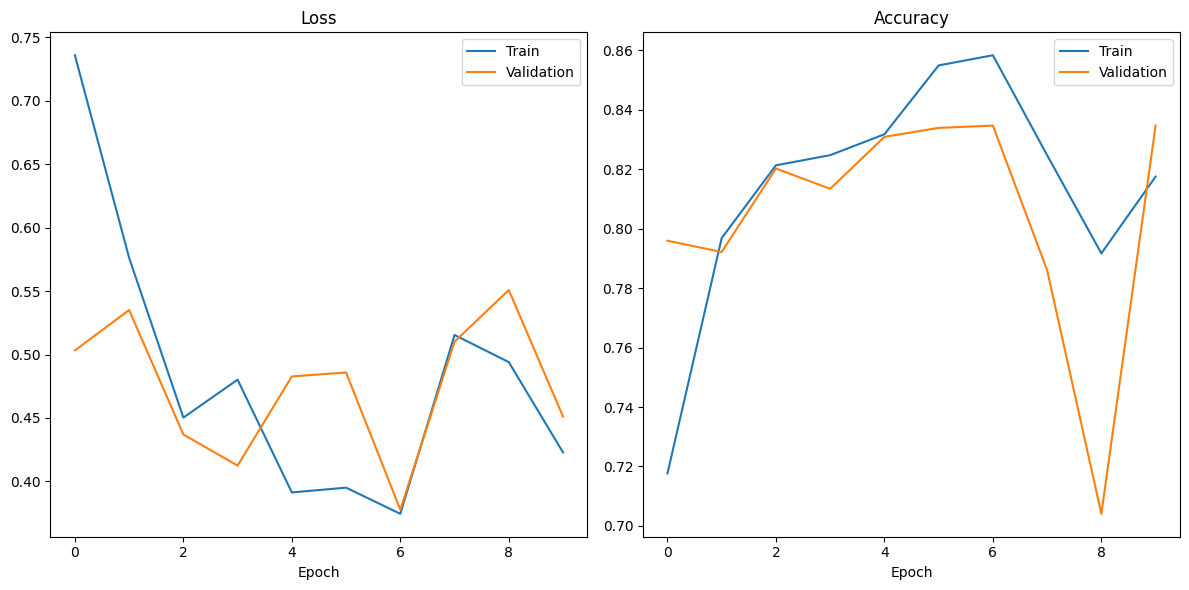

In [10]:
# Lists to store loss and accuracy values for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(10):
    print(f"Epoch {epoch+1}/10")
    
    history = model.fit(X_train, y_train, batch_size=64, epochs=1, validation_data=(X_test, y_test), verbose=0)
    train_loss = history.history['loss'][0]
    train_accuracy = history.history['accuracy'][0]
    
    val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Training Loss: {train_loss:.4f} - Training Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}')
    print("=" * 30)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Finding the Best Hyper Parameters

In [12]:
def create_lstm_model(learning_rate=0.001, lstm_units=128, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(num_words, embedding_dim, input_length=max_seq_len, weights=[embedding_matrix], trainable=False))
    model.add(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Hyperparameer Tuning
- Performs hyperparameter tuning using Randomized Search for the LSTM model.
- Identifies the best hyperparameters (learning rate, LSTM units, dropout rate, batch size) based on accuracy.

In [ ]:


param_dist = {
    'learning_rate': [0.001, 0.01, 0.1],
    'lstm_units': [64, 128, 256],
    'dropout_rate': [0.2, 0.3, 0.4],
    'batch_size': [32, 64, 128]
}

best_score = float('-inf')
best_params = None
for _ in range(10):  # Number of iterations for random search 
    learning_rate = np.random.choice(param_dist['learning_rate'])
    lstm_units = np.random.choice(param_dist['lstm_units'])
    dropout_rate = np.random.choice(param_dist['dropout_rate'])
    batch_size = np.random.choice(param_dist['batch_size'])
    
    model = create_lstm_model(learning_rate=learning_rate, lstm_units=lstm_units, dropout_rate=dropout_rate)
    
    model.fit(X_train, y_train, batch_size=batch_size, epochs=5, verbose=0)
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f'Learning Rate: {learning_rate:.4f}, LSTM Units: {lstm_units}, Dropout Rate: {dropout_rate:.2f}, Batch Size: {batch_size}, Accuracy: {accuracy:.4f}')
    
    if accuracy > best_score:
        best_score = accuracy
        best_params = {
            'learning_rate': learning_rate,
            'lstm_units': lstm_units,
            'dropout_rate': dropout_rate,
            'batch_size': batch_size
        }

print("Best parameters found: ", best_params)
print("Best score: ", best_score)


# Creating model with the best found Parameters

### Creates a model with the best parameters and trains it, visualizing loss and accuracy trends over epochs.

In [28]:
best_model = create_lstm_model(learning_rate=best_params['learning_rate'],
                               lstm_units=best_params['lstm_units'],
                               dropout_rate=best_params['dropout_rate'])

Epoch 1/5
165/165 [==============================] - 69s 416ms/step - loss: 0.3565 - accuracy: 0.8347 - val_loss: 0.3638 - val_accuracy: 0.8437
Epoch 2/5
165/165 [==============================] - 72s 439ms/step - loss: 0.3079 - accuracy: 0.8636 - val_loss: 0.3689 - val_accuracy: 0.8505
Epoch 3/5
165/165 [==============================] - 79s 478ms/step - loss: 0.2798 - accuracy: 0.8782 - val_loss: 0.3134 - val_accuracy: 0.8520
Epoch 4/5
165/165 [==============================] - 76s 461ms/step - loss: 0.2549 - accuracy: 0.8825 - val_loss: 0.3430 - val_accuracy: 0.8520
Epoch 5/5
165/165 [==============================] - 77s 465ms/step - loss: 0.2346 - accuracy: 0.9009 - val_loss: 0.3049 - val_accuracy: 0.8596


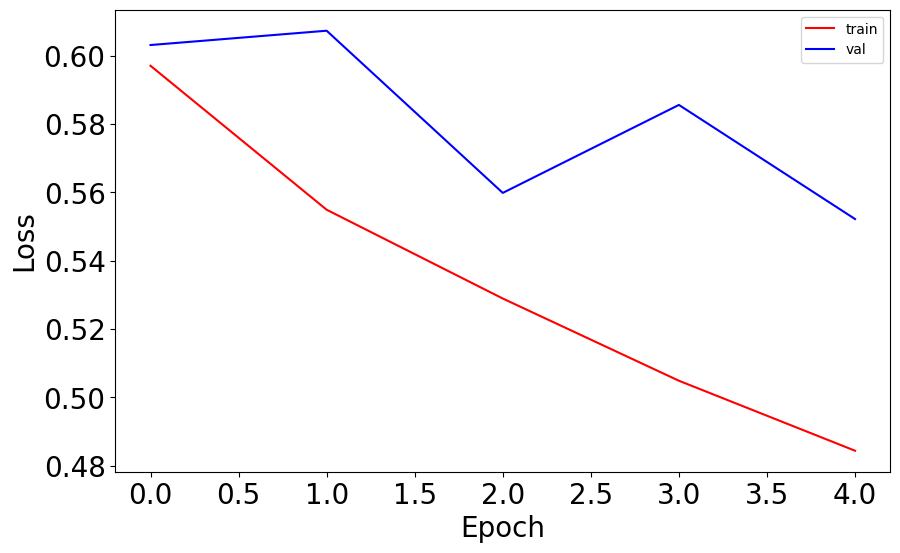

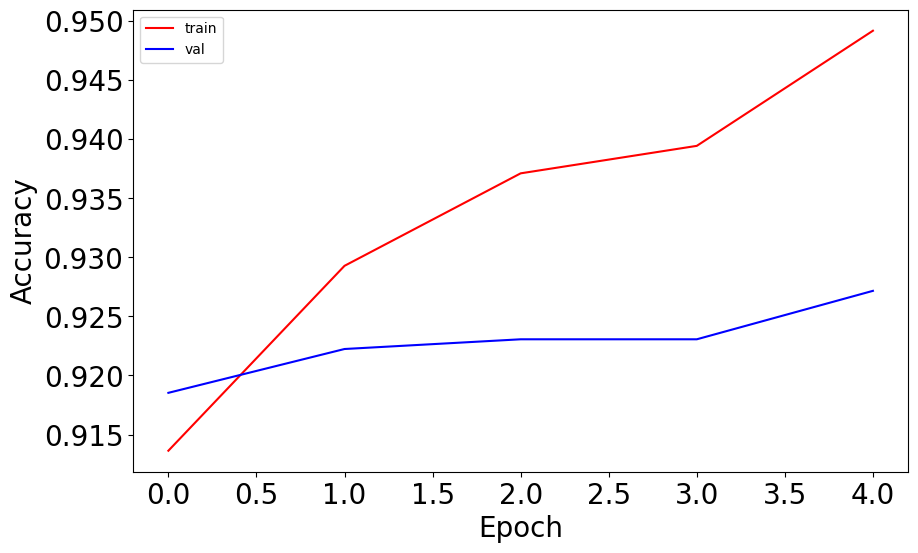

In [30]:
lr_model_history = best_model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test) ,verbose=1)

# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)
# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Testing on Data from other Social Media Sites(Reddit)

- Evaluates the best model on unseen Reddit data, presenting a classification report, confusion matrix heatmap, and ROC curve for performance assessment.

24/24 [==============================] - 2s 87ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.38      0.54       376
           1       0.61      0.99      0.76       376

    accuracy                           0.68       752
   macro avg       0.79      0.68      0.65       752
weighted avg       0.79      0.68      0.65       752



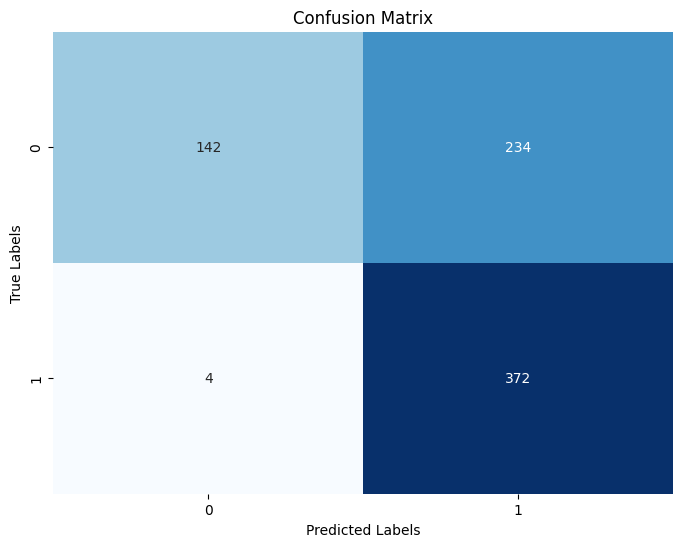

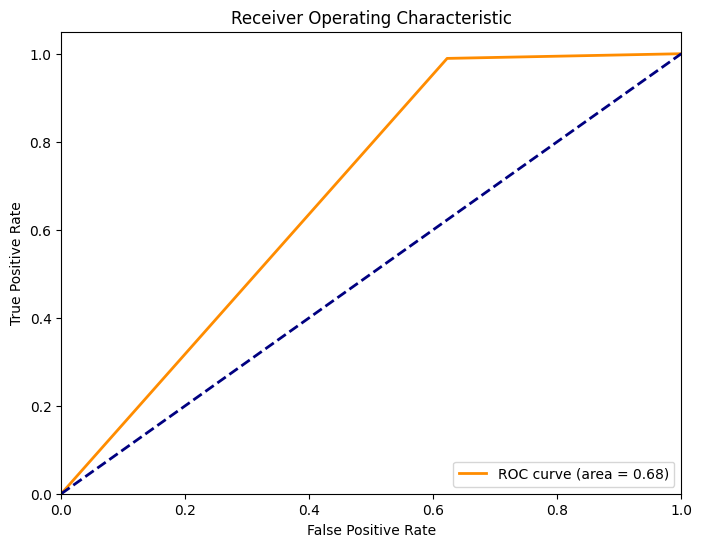

In [36]:
data = pd.read_csv('../Data/Cleaned_Reddit.csv')

unseen_text = data['cleaned_text']
unseen_labels = data['label']

unseen_sequences = tokenizer.texts_to_sequences(unseen_text)
unseen_X = pad_sequences(unseen_sequences, maxlen=max_seq_len)
unseen_y = np.array(unseen_labels)

unseen_y_pred = (best_model.predict(unseen_X) > 0.5).astype("int32")

cm = confusion_matrix(unseen_y, unseen_y_pred)

print("Classification Report:\n", classification_report(unseen_y, unseen_y_pred))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(unseen_y, unseen_y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
